# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# force Pandas to show all rows of features dataframe
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [4]:
azdias.head(n=5)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5          1         1996   
2                      3                 5          1         1979   
3                      1                 2          6         1957   
4                      3                 2          5         1963   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0          -1                 15.0   
1             10.0                 0           3                 21.0   
2             10.0                 1           3                  3.0   
3              1.0                 0           2                  0.0   
4              5.0                 0           3                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0                 0                      0             5.0   
1             1.0                 1                     14             1.0   
2             2.0                 1                     15             3.0   
3             4.0                 1                      8             2.0   
4             2.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3           -1      NaN       NaN        -1   
1              7            6            3      1.0       0.0         2   
2              3            3            2      0.0       0.0         1   
3              4            4            1      0.0       0.0         1   
4              4            2            2      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

Dataset has 85 columns:

In [5]:
azdias.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

Data frame has 891221 entries. Several of the columns have null values.

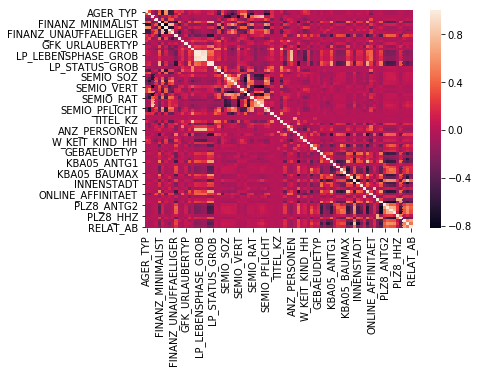

In [7]:
sns.heatmap(azdias.corr())

The heatmap shows that around half of the features are correlated. That suggests that several dimensions can be removed.

Next we read the Features Summary file.

In [8]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [9]:
feat_info

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
30              SEMIO_ERL            person      ordinal             [-1,9]
31             SEMIO_KULT            person      ordinal             [-1,9]
32              SEMIO_RAT            person      ordinal             [-1,9]
33             SEMIO_KRIT            person      ordinal             [-1,9]
34              SEMIO_DOM            person      ordinal             [-1,9]
35             SEMIO_KAEM            person      ordinal             [-1,9]
36          SEMIO_PFLICHT            person      ordinal             [-1,9]
37            SEMIO_TRADV            person      ordinal             [-1,9]
38            SHOPPER_TYP            person  categorical               [-1]
39                SOHO_KZ            person  categorical               [-1]
40               TITEL_KZ            person  categorical             [-1,0]
41               VERS_TYP            person  categorical               [-1]
42               ZABEOTYP            person  categorical             [-1,9]
43               ALTER_HH         household     interval                [0]
44           ANZ_PERSONEN         household      numeric                 []
45              ANZ_TITEL         household      numeric                 []
46     HH_EINKOMMEN_SCORE         household      ordinal             [-1,0]
47           KK_KUNDENTYP         household  categorical               [-1]
48         W_KEIT_KIND_HH         household      ordinal             [-1,0]
49         WOHNDAUER_2008         household      ordinal             [-1,0]
50    ANZ_HAUSHALTE_AKTIV          building      numeric                [0]
51           ANZ_HH_TITEL          building      numeric        

In [10]:
feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

The lists in column 'missing_or_unknown' were encoded as strings. They must first be converted to a list.

In [11]:
feat_info['missing_codes'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(',')).values

In [12]:
feat_info['missing_codes'][:10]

0       [-1, 0]
1    [-1, 0, 9]
2       [-1, 0]
3           [0]
4          [-1]
5          [-1]
6          [-1]
7          [-1]
8          [-1]
9          [-1]
Name: missing_codes, dtype: object

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


In [13]:
def set_nan(df, df_info):
    num_missing=[]

    for i in df.columns:
        a = 0
        a += df[i].isnull().sum()
        for x in feat_info[feat_info['attribute']==i]['missing_codes'].values[0]:
            try:
                a += df[df[i]==int(x)][i].count()
                df.loc[df[i]==int(x),i] = np.nan
            except:
                a += df[df[i]==x][i].count()
                df.loc[df[i]==x,i] = np.nan
        
        num_missing.append(a)

    return num_missing

In [14]:
df = azdias.copy()
num_missing = set_nan(df, feat_info)

/home/bmartins/miniconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [15]:
# sanity checking
len(num_missing)

85

In [16]:
# sanity checking
(df.iloc[:,58]=='XX').values.any()

False

In [17]:
df_feat = feat_info.copy()
df_feat['num_missing'] = num_missing

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
df_feat_mod = df_feat.drop(df_feat[df_feat['num_missing'].values == 0].index)

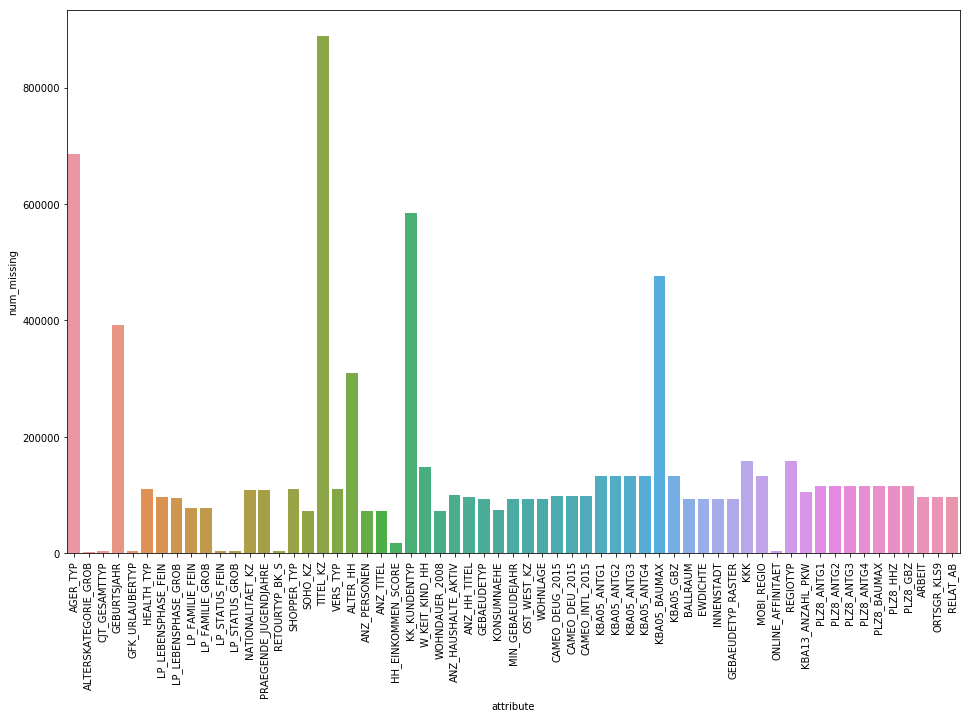

In [19]:
fig,ax = plt.subplots(figsize=(16,10))
#ax.hist(df_feat['num_missing'].values)
#ax.set_xticks(np.arange(0,7))
#ax.set_xticklabels(df_feat['attribute'], rotation=90)
ax = sns.barplot(x="attribute", y="num_missing", data=df_feat_mod)
#ax.set_xticklabels(rotation=90)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

In [20]:
# top 10 for missing entries
df_feat.loc[df_feat['num_missing'].nlargest(10).index.to_list(),'attribute']

40          TITEL_KZ
0           AGER_TYP
47      KK_KUNDENTYP
64      KBA05_BAUMAX
11       GEBURTSJAHR
43          ALTER_HH
70               KKK
73          REGIOTYP
48    W_KEIT_KIND_HH
60       KBA05_ANTG1
Name: attribute, dtype: object

In [21]:
list_drop = df_feat.loc[df_feat['num_missing'].nlargest(10).index.to_list(),'attribute'].to_list()

In [22]:
df.drop(list_drop, axis=1, inplace=True)

In [23]:
df_feat.shape

(85, 6)

In [24]:
df_feat.drop(df_feat[df_feat['attribute'].isin(list_drop)].index.to_list(), axis=0, inplace=True)

In [25]:
# sanity checking
df_feat.shape

(75, 6)

In [26]:
# sanity checking
df.shape

(891221, 75)

Discuss the columns that were dropped

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

_________________________

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [27]:
df['missing'] = df.isnull().sum(axis=1)

In [28]:
df['missing'].describe()

count    891221.000000
mean          4.979533
std          12.056804
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          45.000000
Name: missing, dtype: float64

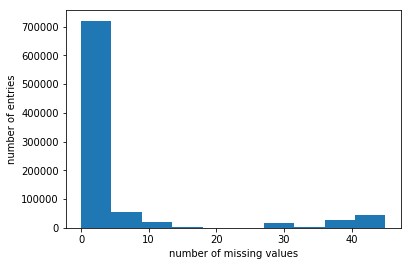

In [29]:
plt.hist(df['missing']);
plt.xlabel('number of missing values')
plt.ylabel('number of entries');

The majority of entries has no missing values. The data was divided in two subsets: below or above 20 missing points.

In [618]:
df_not_missing = df[df['missing']<=20].copy()
df_missing = df[df['missing']>20].copy()

In [619]:
df_not_missing.shape

(797847, 76)

In [620]:
df_not_missing.drop('missing',axis=1,inplace=True)

In [621]:
df_missing.shape

(93374, 76)

In [622]:
df_missing.drop('missing', axis=1, inplace=True)

In [33]:
df_not_missing[df_feat[df_feat['num_missing'].values == 0]['attribute'].to_list()].columns

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')

In [34]:
def compare_codes(col_list, df1, df2):
    fig, ax = plt.subplots(len(col_list), 2, figsize=(14, 14), sharex=True)

    for i in range(len(col_list)):
        sns.countplot(y=col_list[i], data=df1, ax=ax[i,0])
        if (i==0): 
            ax[0,0].set_title("DF 1")
        sns.countplot(y=col_list[i], data=df2, ax=ax[i,1])
        if (i==0): 
            ax[0,1].set_title("DF 2")

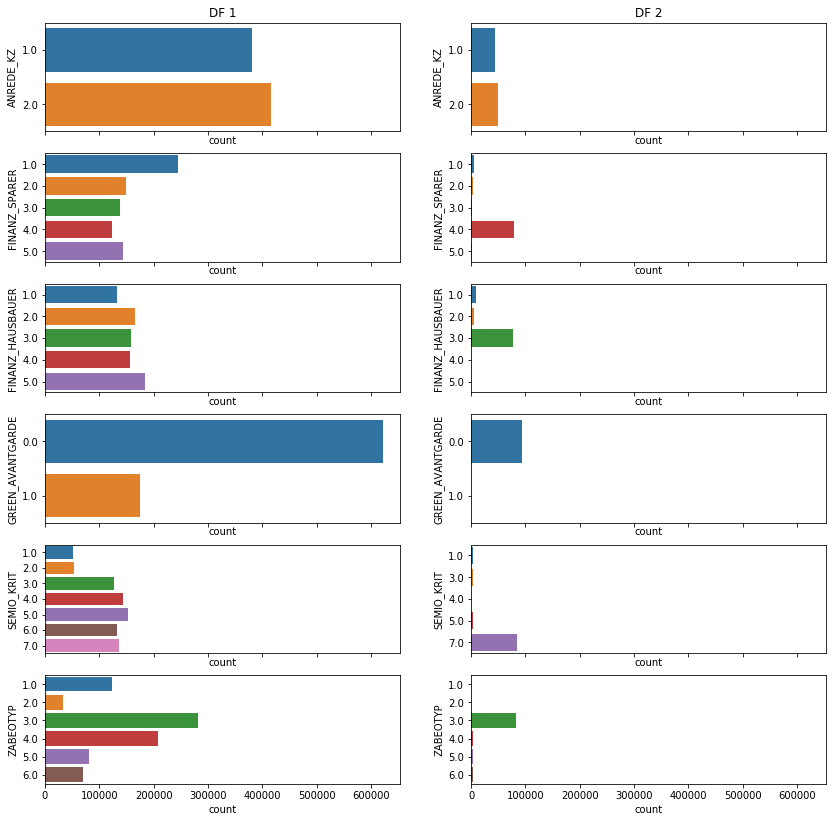

In [35]:
col_list=['ANREDE_KZ','FINANZ_SPARER','FINANZ_HAUSBAUER','GREEN_AVANTGARDE','SEMIO_KRIT','ZABEOTYP']
compare_codes(col_list, df_not_missing, df_missing)

The two subsets are clearly different in their distribution of values.

Continue analysis using df_not_missing

In [36]:
df_2 = df_not_missing.copy()

In [37]:
list_num = df_feat[df_feat['type']=='numeric']['attribute']
list_not_num = df_feat[df_feat['type']!='numeric']['attribute']

In [38]:
imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_num.fit(df_2[list_num])
imputer_num.statistics_

array([1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 1.992e+03, 5.490e+02])

In [39]:
df_2[list_num] = imputer_num.transform(df_2[list_num])

In [40]:
imputer_not_num = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer_not_num.fit(df_2[list_not_num])
imputer_not_num.statistics_

array([3.0, 2.0, 4.0, 3.0, 1.0, 5.0, 1.0, 1.0, 5.0, 6.0, 12.0, 0.0, 3.0,
       1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 14.0, 5.0, 2.0, 2.0, 4.0, 4.0,
       2.0, 6.0, 4.0, 5.0, 4.0, 5.0, 5.0, 3.0, 4.0, 4.0, 1.0, 0.0, 2.0,
       3.0, 6.0, 9.0, 1.0, 1.0, 'W', 3.0, '8', '6B', '51', 0.0, 0.0, 0.0,
       3.0, 6.0, 6.0, 5.0, 4.0, 1.0, 4.0, 2.0, 3.0, 2.0, 0.0, 1.0, 3.0,
       3.0, 4.0, 5.0, 3.0], dtype=object)

In [41]:
df_2[list_not_num] = imputer_not_num.transform(df_2[list_not_num])

In [42]:
#df_2['KBA13_ANZAHL_PKW'].max()

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [43]:
list_cat = df_feat[df_feat['type']=='categorical']['attribute'].to_list()

In [44]:
print('There are {} categorical features'.format(len(list_cat)))

There are 18 categorical features


In [45]:
list_mixed = df_feat[df_feat['type']=='mixed']['attribute'].to_list()

In [46]:
print('There are {} mixed features'.format(len(list_mixed)))

There are 6 mixed features


In [47]:
unique_cat = {i:len(df_2[i].unique()) for i in list_cat}
unique_cat

{'ANREDE_KZ': 2,
 'CJT_GESAMTTYP': 6,
 'FINANZTYP': 6,
 'GFK_URLAUBERTYP': 12,
 'GREEN_AVANTGARDE': 2,
 'LP_FAMILIE_FEIN': 11,
 'LP_FAMILIE_GROB': 5,
 'LP_STATUS_FEIN': 10,
 'LP_STATUS_GROB': 5,
 'NATIONALITAET_KZ': 3,
 'SHOPPER_TYP': 4,
 'SOHO_KZ': 2,
 'VERS_TYP': 2,
 'ZABEOTYP': 6,
 'GEBAEUDETYP': 7,
 'OST_WEST_KZ': 2,
 'CAMEO_DEUG_2015': 9,
 'CAMEO_DEU_2015': 44}

ANREDE_KZ has two numeric levels = {1 - male, 2 - female} and GREEN_AVANTGARDE has two numeric levels = {0 - not member, 1 - member}

SOHO_KZ has two numeric levels.

OST_WEST_KZ has two categorical levels (O, W).

In [48]:
df_feat[df_feat['attribute'].isin(list_mixed)][['attribute','num_missing']]

attribute  num_missing
15    LP_LEBENSPHASE_FEIN        97632
16    LP_LEBENSPHASE_GROB        94572
22  PRAEGENDE_JUGENDJAHRE       108164
56               WOHNLAGE        93148
59        CAMEO_INTL_2015        99352
79            PLZ8_BAUMAX       116515

In [49]:
unique_mixed = {i: len(df_2[i].unique()) for i in list_mixed}
unique_mixed

{'LP_LEBENSPHASE_FEIN': 40,
 'LP_LEBENSPHASE_GROB': 12,
 'PRAEGENDE_JUGENDJAHRE': 15,
 'WOHNLAGE': 8,
 'CAMEO_INTL_2015': 21,
 'PLZ8_BAUMAX': 5}

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [50]:
# binary numeric-encoded variables - do nothing
list_binary = ['ANREDE_KZ','SOHO_KZ','GREEN_AVANTGARDE']

Doing onehot after dealing with mixed variables

In [51]:
#list_onehot = list(filter(lambda x: x not in var_binary, list_cat))

In [52]:
#list_onehot

In [53]:
#one_hot = OneHotEncoder()
#one_hot.fit(df_2[list_onehot])
#one_hot.categories_

In [54]:
#mat_onehot = one_hot.transform(df_2[list_onehot])

In [55]:
#type(mat_onehot)

In [56]:
#mat_onehot.shape

In [57]:
#df_onehot = pd.DataFrame(data = mat_onehot.todense(), columns=one_hot.get_feature_names())

In [58]:
#df_2.drop(list_onehot,axis=1, inplace=True)

In [59]:
#df_2.shape

In [60]:
#df_onehot.shape

In [61]:
#df_2.reset_index(drop=True, inplace=True)
#df_onehot.reset_index(drop=True, inplace=True)
#df_3 = pd.concat( [df_2, df_onehot], axis=1) 

In [62]:
#df_3.shape

In [63]:
#df_3.columns

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [64]:
df_feat[df_feat['type']=='mixed']['attribute']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

### Mixed variable PRAGENDE_JUGENDJAHRE

#### Categories for PRAGENDE_JUGENDJAHRE_intervall
- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s

#### Categories for PRAGENDE_JUGENDJAHRE_trend
- 0: mainstream
- 1: avantgarde

In [65]:
pji_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

In [66]:
df_2['PRAEGENDE_JUGENDJAHRE_intervall'] = df_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pji_dict[int(x)])

In [67]:
pjt_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}

In [68]:
df_2['PRAEGENDE_JUGENDJAHRE_trend'] = df_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pjt_dict[int(x)])

In [69]:
df_2.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

### Mixed variable CAMEO_INTL_2015

#### Categories for CAMEO_INTL_2015_reichtum
- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s

#### Categories for CAMEO_INTL_2015_leben
- 0: mainstream
- 1: avantgarde

In [70]:
cir_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 
            35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
cil_dict = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 
            35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}

In [71]:
df_2['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [72]:
df_2['CAMEO_INTL_2015_reichtum'] = df_2['CAMEO_INTL_2015'].apply(lambda x: cir_dict[int(x)])

In [73]:
df_2['CAMEO_INTL_2015_leben'] = df_2['CAMEO_INTL_2015'].apply(lambda x: cil_dict[int(x)])

In [74]:
df_2.drop('CAMEO_INTL_2015', axis=1, inplace=True)

### Mixed variable LP_LEBENSPHASE_FEIN

#### Categories for LP_LEBENSPHASE_FEIN_alter

1: young age
2: middle age
3: retirement age
4: advanced age
5: higher age

LP_LEBENSPHASE_FEIN_verdiener

- 1: low-income earners 
- 2: average earner
- 3: independent
- 4: homeowner
- 5: top earner
- 6: wealthy

LP_LEBENSPHASE_FEIN_familie
- 1: single
- 2: single parent
- 3: multiperson households
- 4: families
- 5: couples

-  1: single low-income earners of younger age: 1, 1, 1
-  2: single low-income earners of middle age: 2, 1, 1
-  3: single average earners of younger age: 1, 2, 1
-  4: single average earners of middle age: 2, 2, 1
-  5: single low-income earners of advanced age: 4, 1, 1
-  6: single low-income earners at retirement age: 3, 1, 1 
-  7: single average earners of advanced age: 4, 2, 1
-  8: single average earners at retirement age: 3, 2, 1
-  9: single independent persons: 2, 3, 1
- 10: wealthy single homeowners: 6, 3, 1
- 11: single homeowners of advanced age: 4, 4, 1
- 12: single homeowners at retirement age: 3, 4, 1
- 13: single top earners of higher age: 5, 5, 1
- 14: low-income and average earner couples of younger age: 1, 2, 5  
- 15: low-income earner couples of higher age: 5, 1, 5
- 16: average earner couples of higher age: 5, 2, 5
- 17: independent couples: 2, 3, 5
- 18: wealthy homeowner couples of younger age: 1, 6, 5 
- 19: homeowner couples of higher age: 5, 4, 5
- 20: top earner couples of higher age: 5, 5, 5
- 21: single parent low-income earners: 2, 1, 2
- 22: single parent average earners: 2, 2, 2
- 23: single parent high-income earners: 2, 5, 2
- 24: low-income earner families: 2, 1, 4
- 25: average earner families: 2, 2, 4
- 26: independent families: 2, 3, 4
- 27: homeowner families: 2, 4, 4
- 28: top earner families: 2, 5, 4
- 29: low-income earners of younger age from multiperson households: 1, 1, 3
- 30: average earners of younger age from multiperson households: 1, 2, 3
- 31: low-income earners of higher age from multiperson households: 5, 1, 3
- 32: average earners of higher age from multiperson households: 5, 2, 3
- 33: independent persons of younger age from multiperson households: 1, 3, 3
- 34: homeowners of younger age from multiperson households: 1, 4, 3
- 35: top earners of younger age from multiperson households: 1, 5, 3
- 36: independent persons of higher age from multiperson households: 5, 3, 3
- 37: homeowners of advanced age from multiperson households: 4, 4, 3
- 38: homeowners at retirement age from multiperson households: 3, 4, 3
- 39: top earners of middle age from multiperson households: 2, 5, 3
- 40: top earners at retirement age from multiperson households: 3, 5, 3

llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}

#### Categories for CAMEO_INTL_2015_leben
- 0: mainstream
- 1: avantgarde

In [75]:
llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 
           16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 
           31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 
           16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 
           31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 
           16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 
           31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}

In [76]:
df_2['LP_LEBENSPHASE_FEIN_alter'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llfa_dict[int(x)])

In [77]:
df_2['LP_LEBENSPHASE_FEIN_verdiener'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llfv_dict[int(x)])

In [78]:
df_2['LP_LEBENSPHASE_FEIN_familie'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llff_dict[int(x)])

In [79]:
df_2.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

LP_LEBENSPHASE_GROB

LP_LEBENSPHASE_GROB_alter
1: young age
2: middle age
3: higher age

LP_LEBENSPHASE_GROB_verdiener

- 1: low-income and average earner
- 2: high-income

LP_LEBENSPHASE_GROB_familie
- 1: single
- 2: couples
- 3: families
- 4: multiperson
- 5: single parents

-  1: single low-income and average earners of younger age: 1, 1, 1
-  2: single low-income and average earners of higher age: 3, 1, 1
-  3: single high-income earners: 2, 2, 1
-  4: single low-income and average-earner couples: 2, 1, 2
-  5: single high-income earner couples: 2, 2, 2
-  6: single parents: 2, 1, 5
-  7: single low-income and average earner families: 2, 1, 3
-  8: high-income earner families: 2, 2, 3
-  9: average earners of younger age from multiperson households: 1, 1, 4
- 10: low-income and average earners of higher age from multiperson households: 3, 1, 4
- 11: high-income earners of younger age from multiperson households: 1, 2, 4
- 12: high-income earners of higher age from multiperson households: 3, 2, 4

llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
llgv_dict={1:1, 2:1, 3:2, 4:1, 5:2, 6:1, 7:1, 8:2, 9:1, 10:1, 11:2, 12:2}
llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}

In [80]:
llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
llgv_dict={1:1, 2:1, 3:2, 4:1, 5:2, 6:1, 7:1, 8:2, 9:1, 10:1, 11:2, 12:2}
llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}

In [81]:
df_2['LP_LEBENSPHASE_GROB_alter'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llga_dict[int(x)])

In [82]:
df_2['LP_LEBENSPHASE_GROB_verdiener'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llgv_dict[int(x)])

In [83]:
df_2['LP_LEBENSPHASE_GROB_familie'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llgf_dict[int(x)])

In [84]:
df_2.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)

WOHNLAGE

- 1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

PLZ8_BAUMAX

PLZ8_BAUMAX_nummer

- 1: 1-2
- 2: 3-5
- 3: 6-10
- 4: 10+

PLZ8_BAUMAX_art

- 1: family home
- 2: business buildings


-  1: mainly 1-2 family homes: 1,1
-  2: mainly 3-5 family homes: 2,1
-  3: mainly 6-10 family homes: 3,1
-  4: mainly 10+ family homes: 4,1
-  5: mainly business buildings: 1,2



In [85]:
pbn_dict = {1:1, 2:2, 3:3, 4:4, 5:1}
pba_dict = {1:1, 2:1, 3:1, 4:1, 5:2}

In [86]:
df_2['PLZ8_BAUMAX_nummer'] = df_2['PLZ8_BAUMAX'].apply(lambda x: pbn_dict[int(x)])

In [87]:
df_2['PLZ8_BAUMAX_art'] = df_2['PLZ8_BAUMAX'].apply(lambda x: pba_dict[int(x)])

In [88]:
df_2.drop('PLZ8_BAUMAX', axis=1, inplace=True)

### One hot encode

In [89]:
list_mixed_new = ['PRAEGENDE_JUGENDJAHRE_intervall','PRAEGENDE_JUGENDJAHRE_trend',
                  'CAMEO_INTL_2015_reichtum','CAMEO_INTL_2015_leben','LP_LEBENSPHASE_FEIN_alter',
                  'LP_LEBENSPHASE_FEIN_verdiener','LP_LEBENSPHASE_FEIN_familie','LP_LEBENSPHASE_GROB_alter',
                  'LP_LEBENSPHASE_GROB_verdiener','LP_LEBENSPHASE_GROB_familie','WOHNLAGE','PLZ8_BAUMAX_nummer',
                  'PLZ8_BAUMAX_art']
list_cat = list_cat + list_mixed_new
list_onehot = list(filter(lambda x: x not in list_binary, list_cat))

In [90]:
list_onehot

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'PRAEGENDE_JUGENDJAHRE_intervall',
 'PRAEGENDE_JUGENDJAHRE_trend',
 'CAMEO_INTL_2015_reichtum',
 'CAMEO_INTL_2015_leben',
 'LP_LEBENSPHASE_FEIN_alter',
 'LP_LEBENSPHASE_FEIN_verdiener',
 'LP_LEBENSPHASE_FEIN_familie',
 'LP_LEBENSPHASE_GROB_alter',
 'LP_LEBENSPHASE_GROB_verdiener',
 'LP_LEBENSPHASE_GROB_familie',
 'WOHNLAGE',
 'PLZ8_BAUMAX_nummer',
 'PLZ8_BAUMAX_art']

In [91]:
one_hot = OneHotEncoder()
one_hot.fit(df_2[list_onehot])
one_hot.categories_

[array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0],
       dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0],
       dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0], dtype=object),
 array([1.0, 2.0, 3.0], dtype=object),
 array([0.0, 1.0, 2.0, 3.0], dtype=object),
 array([1.0, 2.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0], dtype=object),
 array(['O', 'W'], dtype=object),
 array(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array(['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B',
        '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D',
        '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', 

In [92]:
mat_onehot = one_hot.transform(df_2[list_onehot])

In [93]:
df_onehot = pd.DataFrame(data = mat_onehot.todense(), columns=one_hot.get_feature_names())

In [94]:
list_after_onehot = df_onehot.columns.to_list()

In [95]:
df_2.drop(list_onehot,axis=1, inplace=True)

In [96]:
df_2.reset_index(drop=True, inplace=True)
df_onehot.reset_index(drop=True, inplace=True)

df_3 = pd.concat( [df_2, df_onehot], axis=1) 

In [97]:
df_3.describe()

ALTERSKATEGORIE_GROB      ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count         797847.000000  797847.000000      797847.000000  797847.000000   
mean               2.796094       1.521473           3.058828       2.715981   
std                1.016737       0.499539           1.377560       1.485095   
min                1.000000       1.000000           1.000000       1.000000   
25%                2.000000       1.000000           2.000000       1.000000   
50%                3.000000       2.000000           3.000000       3.000000   
75%                4.000000       2.000000           4.000000       4.000000   
max                4.000000       2.000000           5.000000       5.000000   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count     797847.000000   797847.000000          797847.000000   
mean           3.432915        2.840898               2.658043   
std            1.376914        1.472754               1.399451   
min            1.000000        1.000000               1.000000   
25%            2.000000        1.000000               1.000000   
50%            4.000000        3.000000               2.000000   
75%            5.000000        4.000000               4.000000   
max            5.000000        5.000000               5.000000   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE     HEALTH_TYP  RETOURTYP_BK_S  \
count     797847.000000     797847.000000  797847.000000   797847.000000   
mean           3.114469          0.219580       2.235869        3.452088   
std            1.408006          0.413962       0.756426        1.455018   
min            1.000000          0.000000       1.000000        1.000000   
25%            2.000000          0.000000       2.000000        2.000000   
50%            3.000000          0.000000       2.000000        4.000000   
75%            4.000000          0.000000       3.000000        5.000000   
max            5.000000          1.000000       3.000000        5.000000   

           SEMIO_SOZ      SEMIO_FAM      SEMIO_REL      SEMIO_MAT  \
count  797847.000000  797847.000000  797847.000000  797847.000000   
mean        4.140076       4.113459       3.994397       3.887337   
std         1.940969       1.913677       1.910445       1.913256   
min         1.000000       1.000000       1.000000       1.000000   
25%         2.000000       2.000000       3.000000       2.000000   
50%         4.000000       4.000000       4.000000       4.000000   
75%         6.000000       6.000000       5.000000       5.000000   
max         7.000000       7.000000       7.000000       7.000000   

          SEMIO_VERT     SEMIO_LUST      SEMIO_ERL     SEMIO_KULT  \
count  797847.000000  797847.000000  797847.000000  797847.000000   
mean        4.277313       4.333875       4.622187       4.132068   
std         1.945418       2.102716       1.826790       1.957822   
min         1.000000       1.000000       1.000000       1.000000   
25%         2.000000       2.000000       3.000000       3.000000   
50%         5.000000       5.000000       4.000000       4.000000   
75%         6.000000       6.000000       6.000000       6.000000   
max         7.000000       7.000000       7.000000       7.000000   

           SEMIO_RAT     SEMIO_KRIT      SEMIO_DOM     SEMIO_KAEM  \
count  797847.000000  797847.000000  797847.000000  797847.000000   
mean        3.893778       4.549347       4.554356       4.294259   
std         1.653000       1.760210       1.826161       1.867700   
min         1.000000       1.000000       1.000000       1.000000   
25%         3.000000       3.000000       3.000000       3.000000   
50%         4.000000       5.000000       5.000000       4.000000   
75%         5.000000       6.000000       6.000000       6.000000   
max         7.000000       7.000000       7.000000       7.000000   

       SEMIO_PFLICHT    SEMIO_TRADV        SOHO_KZ   ANZ_PERSONEN  \
count  797847.000000  797847.000000  797847.000000  797847.000000   
me

In [98]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797847 entries, 0 to 797846
Columns: 246 entries, ALTERSKATEGORIE_GROB to x27_2
dtypes: float64(245), int64(1)
memory usage: 1.5 GB


In [99]:
df_3['KBA13_ANZAHL_PKW'].max()

2300.0

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

In [100]:
df_3.shape

(797847, 246)

In [101]:
df_3.isnull().values.any()

False

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [102]:
df_3.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797847 entries, 0 to 797846
Data columns (total 246 columns):
ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                float64
FINANZ_MINIMALIST        float64
FINANZ_SPARER            float64
FINANZ_VORSORGER         float64
FINANZ_ANLEGER           float64
FINANZ_UNAUFFAELLIGER    float64
FINANZ_HAUSBAUER         float64
GREEN_AVANTGARDE         float64
HEALTH_TYP               float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                float64
SEMIO_FAM                float64
SEMIO_REL                float64
SEMIO_MAT                float64
SEMIO_VERT               float64
SEMIO_LUST               float64
SEMIO_ERL                float64
SEMIO_KULT               float64
SEMIO_RAT                float64
SEMIO_KRIT               float64
SEMIO_DOM                float64
SEMIO_KAEM               float64
SEMIO_PFLICHT            float64
SEMIO_TRADV              float64
SOHO_KZ                  float64
ANZ_PERSONEN             float

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [246]:
def clean_data(df, df_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    num_missing = set_nan(df, df_info)
    
    # remove selected columns and rows, ...
    list_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 
                 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 
                 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG1']

    df.drop(list_drop, axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    df['missing'] = df.isnull().sum(axis=1)
    df_not_missing = df[df['missing']<=20]
    df_2 = df_not_missing.copy()
    
    list_num = df_feat[df_feat['type']=='numeric']['attribute']
    list_not_num = df_feat[df_feat['type']!='numeric']['attribute']
    
    imputer_num = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer_num.fit(df_2[list_num])
    df_2[list_num] = imputer_num.transform(df_2[list_num])
    
    imputer_not_num = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer_not_num.fit(df_2[list_not_num])
    df_2[list_not_num] = imputer_not_num.transform(df_2[list_not_num])
   
    
    #pji_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    #pjt_dict = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df_2['PRAEGENDE_JUGENDJAHRE_intervall'] = df_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pji_dict[x])
    df_2['PRAEGENDE_JUGENDJAHRE_trend'] = df_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pjt_dict[x])
    df_2.drop('PRAEGENDE_JUGENDJAHRE', inplace=True)
    
    #cir_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 
    #        35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    #cil_dict = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 
    #        35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}
    df_2['CAMEO_INTL_2015_reichtum'] = df_2['CAMEO_INTL_2015'].apply(lambda x: cir_dict[int(x)])
    df_2['CAMEO_INTL_2015_leben'] = df_2['CAMEO_INTL_2015'].apply(lambda x: cil_dict[int(x)])
    df_2.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    #llfa_dict={1:1, 2:2, 3:1, 4:2, 5:4, 6:3, 7:4, 8:3, 9:2, 10:6, 11:4, 12:3, 13:5, 14:1, 15:5, 
    #       16:5, 17:2, 18:1, 19:5, 20:5, 21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:1, 30:1, 
    #       31:5, 32:5, 33:1, 34:1, 35:1, 36:5, 37:4, 38:3, 39:2, 40:3}

    #llfv_dict={1:1, 2:1, 3:2, 4:2, 5:1, 6:1, 7:2, 8:2, 9:3, 10:3, 11:4, 12:4, 13:5, 14:2, 15:1, 
    #       16:2, 17:3, 18:6, 19:4, 20:5, 21:1, 22:2, 23:5, 24:1, 25:2, 26:3, 27:4, 28:5, 29:1, 30:2, 
    #       31:1, 32:2, 33:3, 34:4, 35:5, 36:3, 37:4, 38:4, 39:5, 40:5}

    #llff_dict={1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:5, 15:5, 
    #       16:5, 17:5, 18:5, 19:5, 20:5, 21:2, 22:2, 23:2, 24:4, 25:4, 26:4, 27:4, 28:4, 29:3, 30:3, 
    #       31:3, 32:3, 33:3, 34:3, 35:3, 36:3, 37:3, 38:3, 39:3, 40:3}
    df_2['LP_LEBENSPHASE_FEIN_alter'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llfa_dict[int(x)])
    df_2['LP_LEBENSPHASE_FEIN_verdiener'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llfv_dict[int(x)])
    df_2['LP_LEBENSPHASE_FEIN_familie'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llff_dict[int(x)])
    df_2.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    #llga_dict={1:1, 2:3, 3:2, 4:2, 5:2, 6:2, 7:2, 8:2, 9:1, 10:3, 11:1, 12:3}
    #llgv_dict={1:1, 2:1, 3:2, 4:1, 5:2, 6:1, 7:1, 8:2, 9:1, 10:1, 11:2, 12:2}
    #llgf_dict={1:1, 2:1, 3:1, 4:2, 5:2, 6:5, 7:3, 8:3, 9:4, 10:4, 11:4, 12:4}
    df_2['LP_LEBENSPHASE_GROB_alter'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llga_dict[int(x)])
    df_2['LP_LEBENSPHASE_GROB_verdiener'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llgv_dict[int(x)])
    df_2['LP_LEBENSPHASE_GROB_familie'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llgf_dict[int(x)])
    df_2.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    
    pbn_dict = {1:1, 2:2, 3:3, 4:4, 5:1}
    pba_dict = {1:1, 2:1, 3:1, 4:1, 5:2}
    df_2['PLZ8_BAUMAX_nummer'] = df_2['PLZ8_BAUMAX'].apply(lambda x: pbn_dict[int(x)])
    df_2['PLZ8_BAUMAX_art'] = df_2['PLZ8_BAUMAX'].apply(lambda x: pba_dict[int(x)])
    df_2.drop('PLZ8_BAUMAX', axis=1, inplace=True)
    
    one_hot = OneHotEncoder()
    one_hot.fit(df_2[list_onehot])
    mat_onehot = one_hot.transform(df_2[list_onehot])
    df_onehot.reset_index(drop=True, inplace=True)
    df_2.drop(list_onehot,axis=1, inplace=True)
    df_2.reset_index(drop=True, inplace=True)
    df_onehot.reset_index(drop=True, inplace=True)
    df_3 = pd.concat( [df_2, df_onehot], axis=1) 
    
    
    # Return the cleaned dataframe.
    
    return df_3
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [104]:
list_scaled = list(filter(lambda x: x not in list_after_onehot, df_3.columns.to_list()))

In [105]:
list_scaled

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'missing']

In [106]:
df_scaled = df_3.copy()

In [107]:
scaler = StandardScaler()
df_scaled[list_scaled] = scaler.fit_transform(df_scaled[list_scaled])

/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [108]:
df_scaled['x14_8B'].unique()

array([0., 1.])

In [109]:
df_scaled.shape

(797847, 246)

(array([ 55671., 231814., 253169., 129734.,  66322.,  24366.,  26143.,
          6411.,   2648.,   1569.]),
 array([-1.83300095, -1.15146309, -0.46992524,  0.21161261,  0.89315046,
         1.57468831,  2.25622616,  2.93776401,  3.61930186,  4.30083971,
         4.98237756]),
 <a list of 10 Patch objects>)

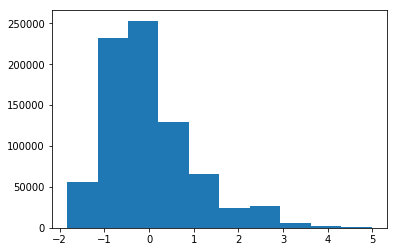

In [111]:
plt.hist(df_scaled['KBA13_ANZAHL_PKW'])

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)m

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [112]:
pca_model = PCA()
X_pca = pca_model.fit_transform(df_scaled)

In [113]:
X_pca.shape

(797847, 246)

In [114]:
pca_model.explained_variance_ratio_

array([1.45408202e-01, 1.16344014e-01, 8.29262125e-02, 4.21396067e-02,
       3.23373420e-02, 2.89562403e-02, 2.79369953e-02, 2.36406066e-02,
       2.01777806e-02, 1.89004351e-02, 1.75320817e-02, 1.65941815e-02,
       1.61466227e-02, 1.43478916e-02, 1.40178806e-02, 1.36536330e-02,
       1.26171425e-02, 1.16717820e-02, 1.14540426e-02, 1.12654381e-02,
       1.07372365e-02, 1.05946305e-02, 9.59783887e-03, 9.09008490e-03,
       8.35674900e-03, 7.56047777e-03, 7.18392731e-03, 6.89417079e-03,
       6.63773567e-03, 6.52085136e-03, 6.28711330e-03, 5.98677235e-03,
       5.81793261e-03, 5.66169725e-03, 5.55016259e-03, 5.44386527e-03,
       5.22207919e-03, 5.08909859e-03, 4.96678461e-03, 4.80201304e-03,
       4.68887304e-03, 4.47958776e-03, 4.38820104e-03, 4.13484524e-03,
       4.02126457e-03, 3.88414634e-03, 3.74131291e-03, 3.73495090e-03,
       3.64094473e-03, 3.54739363e-03, 3.48418103e-03, 3.38490003e-03,
       3.21085503e-03, 3.12872335e-03, 3.06129423e-03, 3.00612466e-03,
      

In [116]:
pca_model.explained_variance_ratio_[:10].sum()

0.5387674358235027

In [117]:
components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df_scaled.keys())

In [ ]:
ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)

In [ ]:
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca_model.components_)+1)]

In [ ]:
components.index = dimensions

In [ ]:
ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)

In [ ]:
variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])

In [ ]:
variance_ratios.index = dimensions

In [ ]:
concat = pd.concat([variance_ratios, components], axis=1)
concat

In [121]:
components

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                 -0.1313     0.0121            -0.2299         0.1583   
1                  0.2519     0.1043             0.0519        -0.2247   
2                  0.0878    -0.3625             0.1557        -0.1138   
3                 -0.0474     0.0468             0.1074        -0.0124   
4                  0.0078     0.0098             0.0526         0.0001   
5                  0.0191    -0.0024             0.0630         0.0002   
6                  0.0139     0.0135            -0.0962         0.0242   
7                 -0.1001     0.0182             0.0399        -0.0507   
8                  0.1418    -0.0339            -0.1911         0.2146   
9                  0.0147     0.1039            -0.0330        -0.1039   
10                 0.0010    -0.0536             0.0621         0.0307   
11                 0.0047    -0.0063             0.0374         0.0050   
12                -0.0288    -0.0159            -0.1194         0.0266   
13                -0.0387    -0.0128            -0.0079        -0.0772   
14                -0.0719     0.0200            -0.0149         0.0008   
15                 0.0014    -0.0003             0.0017         0.0010   
16                 0.1098    -0.0066             0.0367         0.1332   
17                -0.1312     0.0413            -0.0334        -0.0945   
18                -0.0783     0.0270             0.0563        -0.0450   
19                -0.0646     0.0355             0.0014        -0.0393   
20                 0.1508    -0.0484             0.0132         0.0352   
21                 0.0153     0.0119             0.0105        -0.0028   
22                -0.0075     0.0326             0.0627        -0.0195   
23                -0.0029     0.0214            -0.0688         0.1307   
24                -0.0173     0.0384             0.0315         0.0597   
25                 0.0424    -0.0539             0.0107         0.0230   
26                 0.0620    -0.0864            -0.0187         0.0334   
27                 0.0231    -0.0507            -0.0428        -0.0398   
28                 0.0973    -0.0105            -0.1615         0.0142   
29                -0.0134     0.0162            -0.0020         0.0121   
30                 0.0248     0.0308             0.0381         0.0123   
31                 0.0069    -0.0842            -0.0135         0.0257   
32                 0.0123    -0.0211            -0.0069         0.0162   
33                -0.0566     0.0323            -0.0449        -0.0207   
34                -0.0021     0.0218             0.0824        -0.0250   
35                -0.0044    -0.0183            -0.0667         0.0216   
36                -0.0031     0.0690            -0.0603         0.0214   
37                -0.0597    -0.0044            -0.0685         0.0830   
38                 0.0837    -0.0020             0.0568        -0.0406   
39                 0.0045     0.0075             0.0291        -0.0074   
40                -0.1129     0.0247             0.0605        -0.0227   
41                -0.0057    -0.0138             0.0607        -0.0484   
42                -0.0679    -0.0101             0.0368        -0.0621   
43                -0.1272     0.0761             0.0097        -0.0914   
44                 0.0073     0.0988             0.0188        -0.0022   
45                -0.0168    -0.0291            -0.0651        -0.0076   
46                -0.0150     0.0516             0.0234         0.0236   
47                 0.0244    -0.0473            -0.0161        -0.0434   
48                -0.0308     0.0462            -0.0644         0.0407   
49                 0.0308    -0.0427            -0.0256         0.0388   
50                -0.0712     0.0485            -0.0390         0.0092   
51                 0.0594    -0.0393            -0.0100         0.0011   
52                 0.0695    -0.0734            -0.0057         0.0268   
53       

In [119]:
components.loc[0,:].nlargest(10)

PLZ8_ANTG3            0.2222
PLZ8_ANTG4            0.2144
ORTSGR_KLS9           0.2006
EWDICHTE              0.1989
HH_EINKOMMEN_SCORE    0.1966
FINANZ_HAUSBAUER      0.1629
FINANZ_SPARER         0.1583
PLZ8_ANTG2            0.1532
KBA05_ANTG4           0.1509
ARBEIT                0.1397
Name: 0, dtype: float64

In [123]:
evr = []
for i in range(10,100):
    pca_model = PCA(n_components=i)
    X_pca = pca_model.fit_transform(df_scaled)
    evr_tmp = pca_model.explained_variance_ratio_.sum()
    evr.append(evr_tmp)
    print('components {}: {}'.format(i,evr_tmp))

ncomp = np.arange(10,100)

components 10: 0.5387659877393155
components 11: 0.5562862342112708
components 12: 0.5728916164552502
components 13: 0.5890224804570693
components 14: 0.603381557630248
components 15: 0.6174032903174684
components 16: 0.6310548128089158
components 17: 0.643674819506777
components 18: 0.6553435981101422
components 19: 0.6668011286105645
components 20: 0.6780661068243652
components 21: 0.688802371768963
components 22: 0.6993983331914915
components 23: 0.708991142975054
components 24: 0.7180791834333429
components 25: 0.7261992229071652
components 26: 0.7337504564483133
components 27: 0.7409568550735253
components 28: 0.7478463676421062
components 29: 0.7544016833486675
components 30: 0.7610343058008997
components 31: 0.7672393796990811
components 32: 0.7731431034656279
components 33: 0.7788365068759372
components 34: 0.7844897378383946
components 35: 0.7899992874398235
components 36: 0.795479168826126
components 37: 0.8009546495340633
components 38: 0.8059845289835148
components 39: 0.81

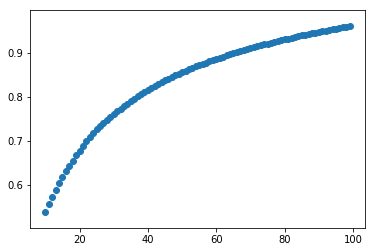

In [124]:
plt.scatter(ncomp, evr)

In [125]:
pca_model = PCA(n_components=66)
X_pca = pca_model.fit_transform(df_scaled)

In [570]:
components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df_scaled.keys())

In [571]:
ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)

In [578]:
dimensions = ['Dim {}'.format(i) for i in range(len(pca_model.components_))]

In [579]:
components.index = dimensions

In [580]:
variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])

In [581]:
variance_ratios.index = dimensions

In [582]:
var_pca = pd.concat([variance_ratios, components], axis=1)

In [583]:
var_pca

Explained_Variance  ALTERSKATEGORIE_GROB  ANREDE_KZ  \
Dim 0               0.1454               -0.1313     0.0121   
Dim 1               0.1163                0.2519     0.1043   
Dim 2               0.0829                0.0878    -0.3625   
Dim 3               0.0421               -0.0474     0.0468   
Dim 4               0.0323                0.0078     0.0098   
Dim 5               0.0290                0.0191    -0.0024   
Dim 6               0.0279                0.0139     0.0135   
Dim 7               0.0236               -0.1001     0.0182   
Dim 8               0.0202                0.1418    -0.0339   
Dim 9               0.0189                0.0147     0.1039   
Dim 10              0.0175                0.0010    -0.0536   
Dim 11              0.0166                0.0047    -0.0063   
Dim 12              0.0161               -0.0288    -0.0159   
Dim 13              0.0143               -0.0387    -0.0128   
Dim 14              0.0140               -0.0719     0.0200   
Dim 15              0.0137                0.0014    -0.0003   
Dim 16              0.0126                0.1098    -0.0066   
Dim 17              0.0117               -0.1312     0.0413   
Dim 18              0.0115               -0.0782     0.0269   
Dim 19              0.0113               -0.0645     0.0355   
Dim 20              0.0107                0.1508    -0.0484   
Dim 21              0.0106                0.0153     0.0119   
Dim 22              0.0096               -0.0075     0.0326   
Dim 23              0.0091               -0.0029     0.0214   
Dim 24              0.0084               -0.0172     0.0383   
Dim 25              0.0076                0.0425    -0.0538   
Dim 26              0.0072                0.0622    -0.0864   
Dim 27              0.0069                0.0229    -0.0508   
Dim 28              0.0066                0.0971    -0.0104   
Dim 29              0.0065               -0.0131     0.0163   
Dim 30              0.0063                0.0250     0.0308   
Dim 31              0.0060                0.0068    -0.0839   
Dim 32              0.0058                0.0127    -0.0211   
Dim 33              0.0057               -0.0573     0.0325   
Dim 34              0.0055               -0.0026     0.0218   
Dim 35              0.0054               -0.0042    -0.0187   
Dim 36              0.0052               -0.0030     0.0691   
Dim 37              0.0051               -0.0601    -0.0044   
Dim 38              0.0050                0.0836    -0.0017   
Dim 39              0.0048                0.0045     0.0075   
Dim 40              0.0047               -0.1121     0.0238   
Dim 41              0.0045               -0.0062    -0.0130   
Dim 42              0.0044               -0.0676    -0.0103   
Dim 43              0.0041               -0.1275     0.0761   
Dim 44              0.0040                0.0108     0.0981   
Dim 45              0.0039               -0.0154    -0.0290   
Dim 46              0.0037               -0.0069     0.0366   
Dim 47              0.0037                0.0268    -0.0598   
Dim 48              0.0036               -0.0384     0.0476   
Dim 49              0.0035                0.0527    -0.0479   
Dim 50              0.0035               -0.0591     0.0400   
Dim 51              0.0034                0.0582    -0.0399   
Dim 52              0.0032                0.0783    -0.0794   
Dim 53              0.0031               -0.0189     0.0102   
Dim 54              0.0030               -0.0194     0.0099   
Dim 55              0.0030                0.0229    -0.0125   
Dim 56              0.0029               -0.0483    -0.0157   
Dim 57              0.0028               -0.0127    -0.0043   
Dim 58              0.0027                0.0251     0.0342   
Dim 59              0.0027                0.0070     0.0814   
Dim 60              0.0027               -0.1231     0.0177   
Dim 61              0.0026               -0.0368     0.0194   
Dim 62              0.0025             

In [584]:
def pca(df):
    pca_model = PCA(n_components=66)
    X_pca = pca_model.fit_transform(df)
    components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df.keys())
    ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)
    dimensions = ['Dim {}'.format(i) for i in range(1,len(pca_model.components_))]
    components.index = dimensions
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])
    variance_ratios.index = dimensions
    var_pca = pd.concat([variance_ratios, components], axis=1)
    
    return pca_model, var_pca, X_pca

In [247]:
def scree_plot_pca(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantiating of PCA in scikit learn
            
    OUTPUT: None
    '''
    
    num_comp = len(pca.explained_variance_ratio_)
    idx = np.arange(num_comp)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(16,6))
    ax = plt.subplot(111)
    ax.bar(idx, vals*10)
    ax.plot(idx, np.cumsum(vals),'r--')
    
    for i in range(num_comp):
#        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), 
#                    (idx[i]+0.2, vals[i]), 
#                    va="bottom", 
#                    ha="center", 
#                    fontsize=12)
       ax.annotate(r"%s" % ((str(vals[i]*100)[:4])), 
                    (idx[i], vals[i]*10), 
                    va="bottom", 
                    ha="center", 
                    fontsize=8)
        
    ax.xaxis.set_tick_params(width=0)
#    ax.yaxis.set_tick_params(width=2, length=12)
    ax.yaxis.set_tick_params(width=0)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    
    plt.title("Explained Variance per Principal Component")

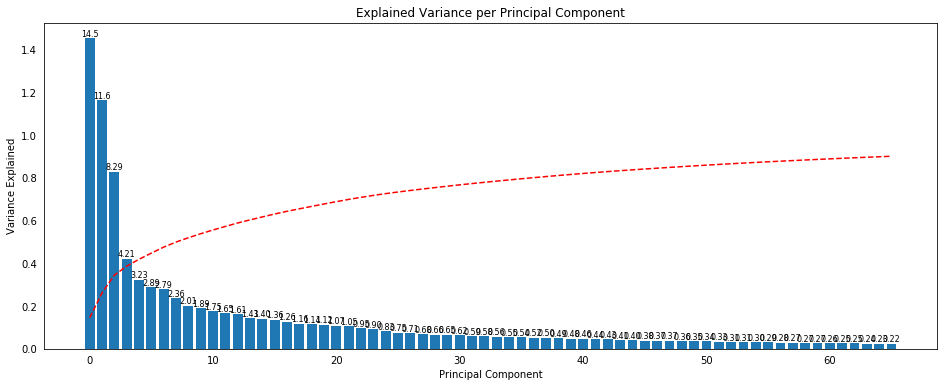

In [147]:
scree_plot_pca(pca_model)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.

- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [236]:
def pca_analysis(var_pca):
    list_df = []
    for i in range(3):
        list_df.append(pd.DataFrame(var_pca.iloc[i,:].sort_values(axis=0, ascending=False)))
        list_df[i]['attribute {}'.format(i+1)] = list_df[i].index
        list_df[i].set_index(np.arange(var_pca.shape[1]), inplace=True)

    return pd.concat([list_df[0], list_df[1], list_df[2]],axis=1)

In [237]:
var_comp = pca_analysis(var_pca)

In [238]:
var_comp.head()

Dim 1         attribute 1   Dim 2           attribute 2   Dim 3  \
0  0.2222          PLZ8_ANTG3  0.2519  ALTERSKATEGORIE_GROB  0.3396   
1  0.2144          PLZ8_ANTG4  0.2343             SEMIO_ERL  0.2581   
2  0.2006         ORTSGR_KLS9  0.2222      FINANZ_VORSORGER  0.2410   
3  0.1989            EWDICHTE  0.1755            SEMIO_LUST  0.2259   
4  0.1966  HH_EINKOMMEN_SCORE  0.1597        RETOURTYP_BK_S  0.1557   

         attribute 3  
0         SEMIO_VERT  
1          SEMIO_SOZ  
2          SEMIO_FAM  
3         SEMIO_KULT  
4  FINANZ_MINIMALIST

In [239]:
var_comp.tail()

Dim 1        attribute 1   Dim 2    attribute 2   Dim 3 attribute 3
242 -0.1688        KONSUMNAEHE -0.2210  SEMIO_PFLICHT -0.2221   SEMIO_RAT
243 -0.2103          KBA05_GBZ -0.2247  FINANZ_SPARER -0.2692  SEMIO_KRIT
244 -0.2156         MOBI_REGIO -0.2257    SEMIO_TRADV -0.3055   SEMIO_DOM
245 -0.2200         PLZ8_ANTG1 -0.2258     SEMIO_KULT -0.3261  SEMIO_KAEM
246 -0.2299  FINANZ_MINIMALIST -0.2549      SEMIO_REL -0.3625   ANREDE_KZ

### Component 1:

#### Top 5 negative:

1 - FINANZ_MINIMALIST: Financial typology - low financial interest  
2 - PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region  
3 - MOBI_REGIO: Movement patterns  
4 - KBA05_GBZ: Number of buildings in the microcell  
5 - KONSUMNAEHE: Distance from building to point of sale (PoS)  

#### Top 5 positive:
1 - PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region  
2 - PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region
3 - ORTSGR_KLS9: Size of community  
4 - EWDICHTE: Density of households per square kilometer  
5 - HH_EINKOMMEN_SCORE: Estimated household net income

### Component 2

#### Top 5 negative: 
1 - SEMIO_REL: Personality typology - religious  
2 - SEMIO_KULT: Personality typology - cultural-minded  
3 - SEMIO_TRADV: Personality typology - tradional-minded  
4 - FINANZ_SPARER: Financial typology - money-saver  
5 - SEMIO_PFLICHT: Personality typology - dutiful  

#### Top 5 positive:
1 - ALTERSKATEGORIE_GROB: Estimated age based on given name analysis  
2 - SEMIO_ERL: Personality typology - event oriented  
3 - FINANZ_VORSORGER: Financial typology - be prepared  
4 - SEMIO_LUST: Personality typology - sensual-minded  
5 - RETOURTYP_BK_S: Return type  

### Component 3

#### Top 5 negative:
1 - ANREDE_KZ: Gender  
2 - SEMIO_KAEM: Personality typology - combative attitude  
3 - SEMIO_DOM: Personality typology - dominant-minded  
4 - SEMIO_KRIT: Personality typology - critical-minded  
5 - SEMIO_RAT: Personality typology - rational  

#### Top 5 positive:
1 - SEMIO_VERT: Personality typology - dreamful   
2 - SEMIO_SOZ: Personality typology - socially-minded    
3 - SEMIO_FAM: Personality typology - family-minded  
4 - SEMIO_KULT: Personality typology - cultural-minded  
5 - FINANZ_MINIMALIST: Financial typology - low financial interest  

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [248]:
k_model = KMeans(n_clusters=10)
k_model_pred = k_model.fit_predict(X_pca)

In [266]:
centroids = k_model.cluster_centers_
centroids.shape

(10, 66)

In [271]:
for i, x in enumerate(centroids):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [257]:
k_model.labels_.shape

(797847,)

In [299]:
(k_model.labels_==0).sum()

128039

In [325]:
def dist_centroid(X_pca, k_model):
    dist = []
    for i, c in enumerate(k_model.cluster_centers_):
        a = np.array([np.sqrt(np.dot((x - c),(x - c))) for x in X_pca[k_model.labels_ == i]])
        #print(a.shape)
        #print(a.sum())
        #print((k_model.labels_==i).sum())
        dist.append(a.sum() / (k_model.labels_ == i).sum())
    
    return np.array(dist).mean()

In [491]:
def scree_plot_kmeans(X_pca):
    k_score = []
    k_dist = []
    k_step = []
    for k in range(1,30):
        k_model = KMeans(n_clusters = k, random_state=34).fit(X_pca)
        a = k_model.score(X_pca)
        k_score.append(a)
        b = dist_centroid(X_pca, k_model)
        print('clusters: {}, score: {}, dist: {}'.format(k, a, b))
        k_dist.append(b)
        k_step.append(k)
    return k_step, k_dist, k_score

In [ ]:
k_step, k_dist, k_score = scree_plot_kmeans(X_pca)

clusters: 1, score: -52683663.041347064, dist: 7.997512545794099
clusters: 2, score: -46377438.32272348, dist: 7.491072113221093
clusters: 3, score: -42895884.13022221, dist: 7.188700219817387
clusters: 4, score: -40817202.4942029, dist: 7.013935052155743
clusters: 5, score: -39271677.402681544, dist: 6.859554873002017
clusters: 6, score: -38054867.02271869, dist: 6.747644038094076
clusters: 7, score: -36875697.85155624, dist: 6.640620504754385
clusters: 8, score: -36055240.06991522, dist: 6.564587177082888
clusters: 9, score: -35359038.237019226, dist: 6.5554110904703595
clusters: 10, score: -34822521.01333947, dist: 6.482754052255501
clusters: 11, score: -34307223.52562779, dist: 6.418788693659642
clusters: 12, score: -33866889.275511004, dist: 6.413153093542498
clusters: 13, score: -33497660.986455135, dist: 6.376808822199371
clusters: 14, score: -32823084.832394723, dist: 6.480380739079378
clusters: 15, score: -32453147.17338614, dist: 6.5398758108728
clusters: 16, score: -31763237

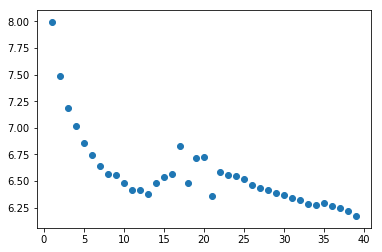

In [499]:
plt.scatter(k_step, k_dist)

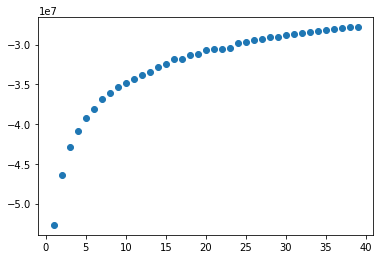

In [500]:
plt.scatter(k_step, k_score)

In [502]:
# 13 clusters was the best result

k_model_final = KMeans(n_clusters = 13, random_state=34).fit(X_pca)
k_score_final = k_model_final.score(X_pca)
k_score_final

-33497660.986455135

In [545]:
k_pop = pd.DataFrame(np.unique(k_model_final.labels_), columns=['cluster'])

In [548]:
k_pop['population'] = np.bincount(k_model_final.labels_) / k_model_final.labels_.shape[0]

In [556]:
k_model_final.labels_.shape

(797847,)

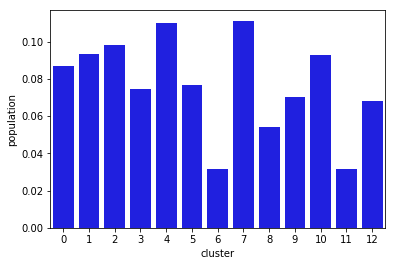

In [549]:
sns.barplot(x = 'cluster', y = 'population', data=k_pop, color='blue')

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [526]:
# First we read customer data
customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [527]:
customer.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      2                 2          2            0   
1                      3                 2          2            0   
2                      4                 4          2            0   
3                      1                 2          6            0   
4                      5                 2          2         1960   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0              4.0                 1           1                 20.0   
1              NaN                 0           1                  NaN   
2              3.0                 1           2                 13.0   
3             10.0                 0           2                  0.0   
4              2.0                 0           3                 31.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  5.0              2.0              2.0            10.0   
1                  NaN              NaN              NaN             NaN   
2                  3.0              1.0              1.0            10.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             1.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             5.0                 1                      4             5.0   
1             NaN                 1                      0             NaN   
2             5.0                 1                      4             5.0   
3             4.0                 1                      1             3.0   
4             1.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          6          5          2          6           6           7   
1          3          6          2          6           7           5   
2          2          2          1          3           3           7   
3          6          5          3          4           7           5   
4          4          5          4          6           5           6   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           4          1           3          1           1   
1          3           4          1           3          3           2   
2          7           1          2           7          5           6   
3          3           4          3           3          3           3   
4          4           5          5           3          5           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              2            1            3      0.0       0.0         1   
1              4            1            3      0.0       0.0         1   
2              4            1            1      0.0       0.0         2   
3              3            4            0      0.0       0.0         1   
4              5            4            1      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [528]:
customer.isnull().values.sum()

2252274

In [529]:
customer.shape

(191652, 85)

In [530]:
def clean_data(df, df_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    num_missing = set_nan(df, df_info)
    
    
    
    
    # remove selected columns and rows, ...
    list_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 
                 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 
                 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG1']

    df.drop(list_drop, axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    df['missing'] = df.isnull().sum(axis=1)
    
    list_num = df_info[df_info['type']=='numeric']['attribute']
    list_not_num = df_info[df_info['type']!='numeric']['attribute']
    
    list_num = list(filter(lambda x: x not in list_drop, list_num))
    list_not_num = list(filter(lambda x: x not in list_drop, list_not_num))
    
    df_2 = pd.DataFrame(data = df[df['missing']<=20])
    
    df_2[list_num] = imputer_num.transform(df_2[list_num])
    df_2[list_not_num] = imputer_not_num.transform(df_2[list_not_num])

    df_2['PRAEGENDE_JUGENDJAHRE_intervall'] = df_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pji_dict[x])
    df_2['PRAEGENDE_JUGENDJAHRE_trend'] = df_2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: pjt_dict[x])
    df_2.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    df_2['CAMEO_INTL_2015_reichtum'] = df_2['CAMEO_INTL_2015'].apply(lambda x: cir_dict[int(x)])
    df_2['CAMEO_INTL_2015_leben'] = df_2['CAMEO_INTL_2015'].apply(lambda x: cil_dict[int(x)])
    df_2.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    df_2['LP_LEBENSPHASE_FEIN_alter'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llfa_dict[int(x)])
    df_2['LP_LEBENSPHASE_FEIN_verdiener'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llfv_dict[int(x)])
    df_2['LP_LEBENSPHASE_FEIN_familie'] = df_2['LP_LEBENSPHASE_FEIN'].apply(lambda x: llff_dict[int(x)])
    df_2.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    df_2['LP_LEBENSPHASE_GROB_alter'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llga_dict[int(x)])
    df_2['LP_LEBENSPHASE_GROB_verdiener'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llgv_dict[int(x)])
    df_2['LP_LEBENSPHASE_GROB_familie'] = df_2['LP_LEBENSPHASE_GROB'].apply(lambda x: llgf_dict[int(x)])
    df_2.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    
    df_2['PLZ8_BAUMAX_nummer'] = df_2['PLZ8_BAUMAX'].apply(lambda x: pbn_dict[int(x)])
    df_2['PLZ8_BAUMAX_art'] = df_2['PLZ8_BAUMAX'].apply(lambda x: pba_dict[int(x)])
    df_2.drop('PLZ8_BAUMAX', axis=1, inplace=True)
    
    mat_onehot = one_hot.transform(df_2[list_onehot])
    df_onehot = pd.DataFrame(data = mat_onehot.todense(), columns=one_hot.get_feature_names())
    df_onehot.reset_index(drop=True, inplace=True)
    df_2.drop(list_onehot,axis=1, inplace=True)
    df_2.reset_index(drop=True, inplace=True)
    
    # Return the cleaned dataframe.
    
    return pd.concat([df_2, df_onehot], axis=1) 
    

In [531]:
customer_clean = clean_data(customer, feat_info)

/home/bmartins/miniconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [532]:
customer_clean.isnull().values.any()

False

In [533]:
customer_clean.shape

(141690, 246)

In [534]:
# pca steps
customer_clean[list_scaled] = scaler.transform(customer_clean[list_scaled])
customer_pca = pca_model.transform(customer_clean)

/home/bmartins/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [535]:
customer_pca.shape

(141690, 66)

In [536]:
# k-means
customer_kmeans = k_model_final.predict(customer_pca)

In [552]:
k_pop_customer = pd.DataFrame(np.unique(k_model_final.labels_), columns=['cluster'])

In [557]:
customer_kmeans.shape

(141690,)

In [558]:
k_pop_customer['population'] = np.bincount(customer_kmeans) / customer_kmeans.shape[0]

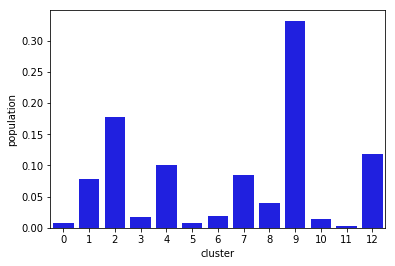

In [559]:
sns.barplot(x = 'cluster', y = 'population', data=k_pop_customer, color='blue')

In [562]:
k_pop_customer['difference'] = k_pop_customer['population'] - k_pop['population']

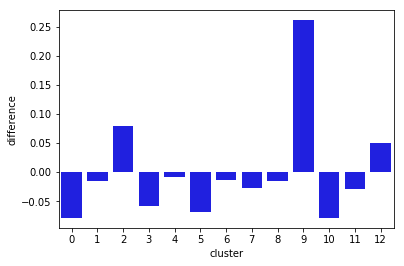

In [563]:
sns.barplot(x = 'cluster', y = 'difference', data=k_pop_customer, color='blue')

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [586]:
list_df = []
for i,x in enumerate([2,9]):
    list_df.append(pd.DataFrame(var_pca.iloc[x,:].sort_values(axis=0, ascending=False)))
    list_df[i]['attribute {}'.format(x)] = list_df[i].index
    list_df[i].set_index(np.arange(var_pca.shape[1]), inplace=True)

customer_profile = pd.concat([x for x in list_df],axis=1)

In [588]:
customer_profile.head()

Dim 2        attribute 2   Dim 9       attribute 9
0  0.3396         SEMIO_VERT  0.3604         SEMIO_MAT
1  0.2581          SEMIO_SOZ  0.1878       SEMIO_TRADV
2  0.2410          SEMIO_FAM  0.1846         ANZ_TITEL
3  0.2259         SEMIO_KULT  0.1839      ANZ_HH_TITEL
4  0.1557  FINANZ_MINIMALIST  0.1823  FINANZ_HAUSBAUER

In [590]:
customer_profile.tail()

Dim 2 attribute 2   Dim 9         attribute 9
242 -0.2221   SEMIO_RAT -0.1315            RELAT_AB
243 -0.2692  SEMIO_KRIT -0.1551  GEBAEUDETYP_RASTER
244 -0.3055   SEMIO_DOM -0.1616              ARBEIT
245 -0.3261  SEMIO_KAEM -0.1696              x9_2.0
246 -0.3625   ANREDE_KZ -0.5360          HEALTH_TYP

Attribute 9

Postive  
1 - SEMIO_MAT: Personality typology - materialistic  
2 - SEMIO_TRADV: Personality typology - traditional-minded  
3 - ANZ_TITEL: Number of professional academic title holders in household
4 - ANZ_HH_TITEL: Number of professional academic title holders in building
5 - FINANZ_HAUSBAUER: Financial typology - home ownership

Negative. 
1 - HEALTH_TYP: Health typology
2 - x9_2.0: came from onehot encoding
3 - ARBEIT: Share of unemployment in community
4 - GEBAEUDETYP_RASTER: Ratio of residential to commercial activity (1 - business cell, 5 - residential cell)  
5 - RELAT_AB: Share of unemployment relative to county in which community is contained (1 - very low). 

In [623]:
centers = pca_model.inverse_transform(k_model_final.cluster_centers_)

In [625]:
centers

array([[-1.24112551e+00,  1.00383053e+00, -1.34319776e+00, ...,
         1.70896716e-01,  7.32703740e-01,  2.67296260e-01],
       [ 6.92348507e-01,  8.41172555e-01,  4.85828113e-01, ...,
        -9.84623516e-03,  9.99756418e-01,  2.43582160e-04],
       [ 5.03825912e-01, -8.91548741e-01,  1.08775697e+00, ...,
        -1.18925935e-02,  9.96248766e-01,  3.75123377e-03],
       ...,
       [-1.07567440e+00,  8.98157063e-01, -5.68294556e-01, ...,
        -1.14147954e-02,  9.83956256e-01,  1.60437442e-02],
       [-1.27062492e-01,  4.61280874e-01, -1.16551614e+00, ...,
         9.95339511e-02,  7.92238457e-01,  2.07761543e-01],
       [ 5.92803761e-01,  8.94447699e-01,  8.32098924e-01, ...,
         1.22127839e-02,  9.87268974e-01,  1.27310256e-02]])

In [626]:
df_centers = pd.DataFrame(centers, columns = df_scaled.keys())

In [628]:
df_centers.shape

(13, 246)

In [629]:
df_centers[list_scaled] = scaler.inverse_transform(df_centers[list_scaled])

In [630]:
df_centers

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0               1.534196   2.022926           1.208494       4.275233   
1               3.500030   1.941672           3.728085       1.795975   
2               3.308352   1.076110           4.557277       1.772906   
3               1.776247   1.000912           2.983315       4.045276   
4               3.339423   1.012899           3.330567       1.963723   
5               1.821539   0.971937           1.909983       4.350678   
6               2.783065   1.523318           3.807623       2.711772   
7               3.528305   1.994601           2.515134       1.885679   
8               3.341554   1.529022           2.555618       2.125558   
9               3.339211   1.024607           4.827222       1.686114   
10              1.702416   1.970138           2.275969       3.950738   
11              2.666905   1.751901           1.453261       4.445329   
12              3.398819   1.968285           4.205093       1.674122   

    FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0           2.138794        4.116762               3.729210          4.231532   
1           4.192458        2.963413               1.878256          2.835074   
2           4.167901        2.271447               1.860711          2.154934   
3           2.147034        3.848935               4.019384          2.360679   
4           4.224671        1.624275               1.768929          3.490094   
5           2.048182        3.445495               3.737087          3.590051   
6           3.206865        2.880636               3.712885          1.247260   
7           4.290494        2.258906               1.788994          4.222901   
8           4.006580        1.937326               1.638573          4.151338   
9           4.226690        1.576828               2.127971          1.928971   
10          2.184181        4.292977               3.908491          2.911756   
11          2.686938        4.570777               4.016571          4.333012   
12          4.144180        2.215213               2.195237          2.304618   

    GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  \
0           0.041225    2.198178        2.367771   3.196816   4.000499   
1           0.015761    2.106350        3.287849   2.708572   2.209444   
2           0.007332    2.375492        3.710197   4.682740   4.627892   
3           0.295354    2.162103        2.544346   6.796795   6.798079   
4           0.097048    2.401157        4.449040   4.964210   5.098015   
5           0.133190    2.370186        2.748844   6.754444   6.783510   
6           0.202454    1.982372        3.444171   3.197490   4.155647   
7           0.072278    2.001731        4.214387   3.160047   2.122309   
8           0.048149    2.254544        4.234146   3.999504   3.732680   
9           0.978387    2.085781        3.983269   4.919397   4.541810   
10          0.193732    2.293654        2.470483   2.650348   3.573798   
11          0.041757    2.976403        4.129415   3.261858   4.578976   
12          0.965401    2.138461        3.473721   3.138003   2.218365   

    SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  \
0    5.486189   4.884588    2.278492    2.654211   4.095367    4.306348   
1    2.190409   2.603274    2.959150    4.900381   6.439293    2.042915   
2    3.772362   3.202221    5.932666    4.910601   4.364915    4.944082   
3    6.293042   5.312273    6.185217    2.985835   2.236367    6.741637   
4    3.781482   4.222680    5.910375    5.070433   4.194821    5.141483   
5    6.199217   5.177403    6.086731    2.748518   2.167822    6.753649   
6    3.796765   4.704882    5.147644    3.069620   4.530880    3.572032   
7    1.969824   2.621472    2.693310    5.264730   6.518309    1.714036   
8    3.068559   3.274622    4.077909    5.174454   5.364830    3.516073   
9    3.759490   3.825595    6.258035    5.351602   4.044085

In [603]:
df_3

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        1.0        2.0                1.0            5.0   
1                        3.0        2.0                1.0            4.0   
2                        4.0        2.0                4.0            2.0   
3                        3.0        1.0                4.0            3.0   
4                        1.0        2.0                3.0            1.0   
5                        2.0        2.0                1.0            5.0   
6                        1.0        1.0                3.0            3.0   
7                        3.0        1.0                4.0            4.0   
8                        3.0        2.0                2.0            4.0   
9                        3.0        2.0                2.0            2.0   
10                       3.0        1.0                5.0            3.0   
11                       1.0        2.0                1.0            4.0   
12                       4.0        2.0                4.0            1.0   
13                       1.0        2.0                4.0            3.0   
14                       2.0        2.0                2.0            4.0   
15                       3.0        1.0                5.0            2.0   
16                       2.0        2.0                4.0            3.0   
17                       2.0        1.0                3.0            4.0   
18                       1.0        1.0                1.0            5.0   
19                       3.0        1.0                5.0            3.0   
20                       1.0        1.0                3.0            5.0   
21                       3.0        1.0                5.0            2.0   
22                       3.0        1.0                3.0            3.0   
23                       3.0        1.0                3.0            2.0   
24                       4.0        2.0                5.0            1.0   
25                       2.0        2.0                1.0            5.0   
26                       1.0        1.0                5.0            4.0   
27                       2.0        2.0                2.0            2.0   
28                       1.0        2.0                4.0            1.0   
29                       3.0        2.0                2.0            3.0   
30                       4.0        1.0                5.0            1.0   
31                       2.0        2.0                3.0            3.0   
32                       4.0        1.0                5.0            3.0   
33                       4.0        2.0                3.0            2.0   
34                       1.0        2.0                2.0            5.0   
35                       1.0        2.0                3.0            4.0   
36                       1.0        2.0                1.0            5.0   
37                       3.0        2.0                3.0            2.0   
38                       4.0        2.0                5.0            1.0   
39                       4.0        2.0                4.0            1.0   
40                       2.0        1.0                4.0            5.0   
41                       3.0        1.0                2.0            5.0   
42                       1.0        1.0                2.0            5.0   
43                       1.0        2.0                1.0            4.0   
44                       3.0        2.0                2.0            3.0   
45                       2.0        1.0                4.0            3.0   
46                       1.0        2.0                1.0            5.0   
47                       2.0        2.0                3.0            3.0   
48                       2.0        1.0                2.0            5.0   
49                       2.0        1.0                3.0            2.0   
50                       2.0        1.0                2.0            4.0   
51  

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)